In [1]:
%%capture
!pip install pyspark

In [2]:
import json
import sys
import time

import pandas as pd
import pyspark.sql.functions as f
import pyspark.sql.types as t

from operator import add
from functools import reduce
from fractions import Fraction
from typing import Tuple, Optional, Iterator
from pprint import pprint
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.utils import AnalysisException
from sklearn.linear_model import LinearRegression
from py4j.protocol import Py4JJavaError

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
spark = (
    SparkSession
    .builder
    .appName("app")
    .getOrCreate()
)
# методы rdd находятся в объекте sparkContext
sc = spark.sparkContext
spark.sparkContext.setLogLevel("WARN")

читаем данные. их проблема в том, что каждый паркет файл может содержать разный набор колонок. Чтобы избежать ошибок при чтении, используем unionByName. Данная команда объединяет строки df. Уникальные колонки будут содержать пропуски там, где их не было

In [4]:
gsod = (
    reduce(
        lambda x, y: x.unionByName(y, allowMissingColumns=True),
        [
            spark.read.parquet(f"/content/gdrive/MyDrive/gsod{year}.parquet")
            for year in range(2015, 2021)
        ],
    )
    .dropna(subset=["year", "mo", "da", "temp"])
    .where(f.col("temp") != 9999.9)
    .drop("date")
)
gsod.show(5)

+------+-----+----+---+---+-----+----------+-----+----------+------+---------+------+---------+-----+-----------+----+----------+-----+-----+-----+--------+-----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+
|   stn| wban|year| mo| da| temp|count_temp| dewp|count_dewp|   slp|count_slp|   stp|count_stp|visib|count_visib|wdsp|count_wdsp|mxpsd| gust|  max|flag_max|  min|flag_min|prcp|flag_prcp| sndp|fog|rain_drizzle|snow_ice_pellets|hail|thunder|tornado_funnel_cloud|
+------+-----+----+---+---+-----+----------+-----+----------+------+---------+------+---------+-----+-----------+----+----------+-----+-----+-----+--------+-----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+
|711410|99999|2015| 03| 05|-33.2|         4|-40.1|         4|1004.2|        4|1001.4|        4|999.9|          0| 6.8|         4|  9.9|999.9|-28.8|    NULL|-37.8|    NULL| 0.0|        C|999.9|  0|           0|        

#### pandas UDF от Series к Series (скалярный UDF)  
при возможности лучше использовать pandas udf вместо обычного python udf, так как в pandas хорошо оптимизированы действия с объектами Series  
но перед использованием pandas udf объект автоматически сериализуется с помощью PyArrow, что также требует времени

схематичное сравнение работы python и pandas udf

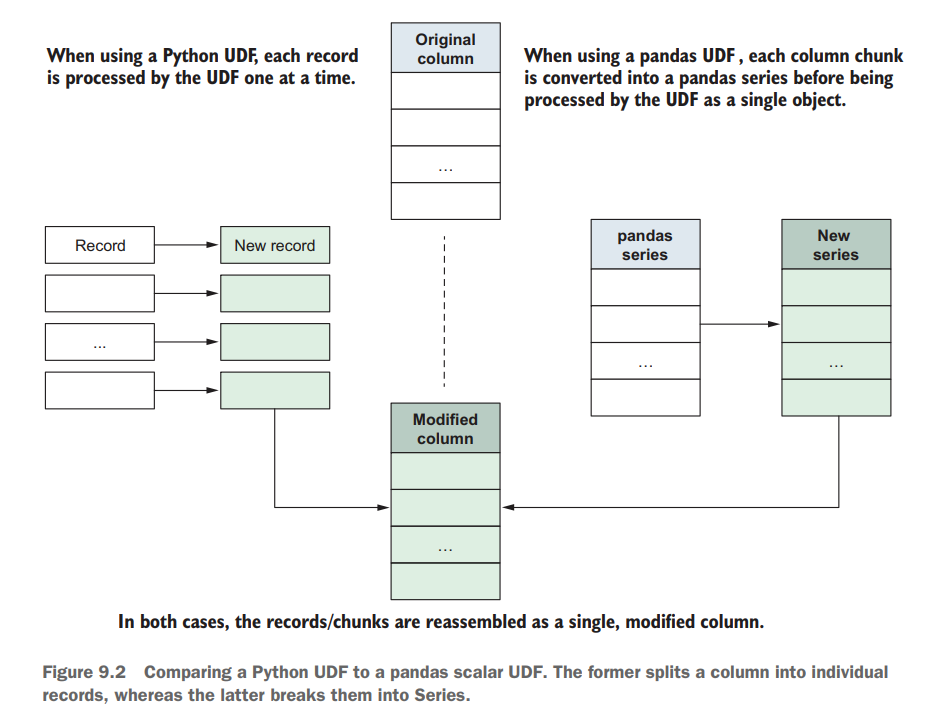

создание pandas_udf, которая принимает серию из температуры в фаренгейтах, а выдает серию из температуры в цельсиях.  
при объявлении pandas_udf задаем тип DoubleType, так как возвращаемая серия будет состоять из элементов с плавающей точкой

In [5]:
@f.pandas_udf(t.DoubleType())
def f_to_c(degrees: pd.Series) -> pd.Series:
    """Transforms Farhenheit to Celcius."""
    return (degrees - 32) * 5 / 9

gsod = gsod.withColumn(
    'temp_c', f_to_c(f.col('temp'))
)
gsod.show(5)

+------+-----+----+---+---+-----+----------+-----+----------+------+---------+------+---------+-----+-----------+----+----------+-----+-----+-----+--------+-----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+------------------+
|   stn| wban|year| mo| da| temp|count_temp| dewp|count_dewp|   slp|count_slp|   stp|count_stp|visib|count_visib|wdsp|count_wdsp|mxpsd| gust|  max|flag_max|  min|flag_min|prcp|flag_prcp| sndp|fog|rain_drizzle|snow_ice_pellets|hail|thunder|tornado_funnel_cloud|            temp_c|
+------+-----+----+---+---+-----+----------+-----+----------+------+---------+------+---------+-----+-----------+----+----------+-----+-----+-----+--------+-----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+------------------+
|711410|99999|2015| 03| 05|-33.2|         4|-40.1|         4|1004.2|        4|1001.4|        4|999.9|          0| 6.8|         4|  9.9|999.9|-28.8|    NULL|-37.

#### pandas UDF от итератора Series к итератору Series  
таки udf пользны тогда, когда перед выполнением действия над series требуется выполнить операцию единожды (не для каждого элемета) это называется холожный старт.   
pyspark самостоятельно разбивает подаваемый series на батчи и каждый батч обрабатывается на своем воркере. Операция, которая выполняется перед циклом прохода по батчам - операция холодного запуска, выполняемая на каждом воркере
в самой функции используется не return, а yield, так как мы возвращаем батчи итерируемого объекта

In [6]:
@f.pandas_udf(t.DoubleType())
def f_to_c(degrees: Iterator[pd.Series]) -> Iterator[pd.Series]:
    """Transforms Farhenheit to Celcius."""
    time.sleep(5)  # холодный запуск
    for batch in degrees:
        yield (batch - 32) * 5 / 9

gsod = gsod.withColumn(
    'temp_c', f_to_c(f.col('temp'))
)
gsod.show(5)

+------+-----+----+---+---+-----+----------+-----+----------+------+---------+------+---------+-----+-----------+----+----------+-----+-----+-----+--------+-----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+------------------+
|   stn| wban|year| mo| da| temp|count_temp| dewp|count_dewp|   slp|count_slp|   stp|count_stp|visib|count_visib|wdsp|count_wdsp|mxpsd| gust|  max|flag_max|  min|flag_min|prcp|flag_prcp| sndp|fog|rain_drizzle|snow_ice_pellets|hail|thunder|tornado_funnel_cloud|            temp_c|
+------+-----+----+---+---+-----+----------+-----+----------+------+---------+------+---------+-----+-----------+----+----------+-----+-----+-----+--------+-----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+------------------+
|711410|99999|2015| 03| 05|-33.2|         4|-40.1|         4|1004.2|        4|1001.4|        4|999.9|          0| 6.8|         4|  9.9|999.9|-28.8|    NULL|-37.

#### pandas UDF от итератора множества Series к итератору Series

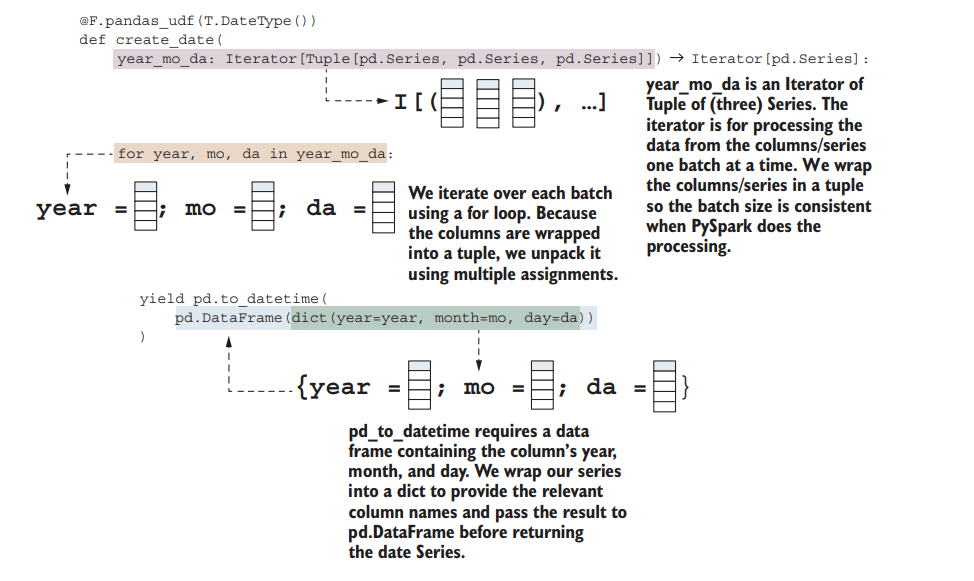

задача - получить колонку с датой, имея колонки year, mo, da

In [7]:
@f.pandas_udf(t.DateType())
def create_date(
    year_mo_da: Iterator[Tuple[pd.Series, pd.Series, pd.Series]]
) -> Iterator[pd.Series]:
    for year,mo,da in year_mo_da:
        yield pd.to_datetime(
            pd.DataFrame(dict(year=year, month=mo, day=da))
        )

# gsod = gsod.withColumns(
#     'date', create_date(f.col('year'), f.col('mo'), f.col('da'))
# )
gsod.select(
    create_date(f.col('year'), f.col('mo'), f.col('da')).alias('date')
).show(5)

+----------+
|      date|
+----------+
|2015-03-05|
|2015-01-21|
|2015-08-13|
|2015-10-01|
|2015-10-08|
+----------+
only showing top 5 rows



по умолчанию pyspark стремится к 10000 объектов в батче. данный параметр можно настроить, используя spark.sql.execution.arrow
.maxRecordsPerBatch

#### UDFs на сгруппированных данных  
используется в том случае, когда состав батчей иммет значение

задача - определить коэффициент наклона линейной регрессии для предсказания температуры по дню месяца в разрезе каждой станции (stn) каждого года и каждого месяца

In [8]:
@f.pandas_udf(t.DoubleType())
def rate_of_change_temperature(day : pd.Series, temp : pd.Series) -> float:
    """Returns the slope of the daily temperature for a given period of time."""
    return(
        LinearRegression()
        .fit(day.astype(int).values.reshape(-1,1), temp)
        .coef_[0]
    )

a = gsod.groupby('stn', 'year', 'mo').agg(
    rate_of_change_temperature(f.col('da'), f.col('temp'))
    .alias('rt_chg_temp')
)

данная группировка делает преобразование series к скаляру, так как для каждого батча (каждой группы) возвращается одно число

In [9]:
a.filter("stn == '008411' and year == 2015").show(100)

+------+----+---+--------------------+
|   stn|year| mo|         rt_chg_temp|
+------+----+---+--------------------+
|008411|2015| 01|0.012096774193548272|
|008411|2015| 02|-0.05555555555555...|
|008411|2015| 03| 0.05056451612903227|
|008411|2015| 04| 0.06909899888765292|
|008411|2015| 05| 0.03088709677419354|
|008411|2015| 06|-0.09539488320355966|
|008411|2015| 07|-1.20967741935420...|
|008411|2015| 08| 0.03850806451612911|
|008411|2015| 09|-0.01893214682981...|
|008411|2015| 10|0.021693548387096827|
|008411|2015| 11| 0.03370411568409329|
|008411|2015| 12|-0.04769744160177971|
+------+----+---+--------------------+



вывести масштбированную температу для каждой группы. То есть температура должны быть в формате от 0 до 1.  
данный вид группировки принимает pandas df для конкретной группы и выдает измененный pandas df. в нашем случае добавлен новый столбец и удалены ненужные  
метод assign для df добавит к df новый столбец


In [13]:
def scale_temperature(temp_by_day: pd.DataFrame) -> pd.DataFrame:
    """Returns a simple normalization of the temperature for a site.
    If the temperature is constant for the whole window, defaults to 0.5."""
    temp = temp_by_day.temp
    # выбираем нужные столбцы
    answer = temp_by_day[["stn", "year", "mo", "da", "temp"]]
    if temp.min() == temp.max():
        return answer.assign(temp_norm=0.5)
    return answer.assign(
        temp_norm=(temp - temp.min()) / (temp.max() - temp.min())
    )

в данном подходе вместо agg используется applyInPandas  
схему можно задавать и в StuctTupe формате  

In [14]:
gsod_map = gsod.groupby("stn", "year", "mo").applyInPandas(
    scale_temperature,
    schema=(
        "stn string, year string, mo string, "
        "da string, temp double, temp_norm double"
    ),
)
gsod_map.show()

+------+----+---+---+----+-------------------+
|   stn|year| mo| da|temp|          temp_norm|
+------+----+---+---+----+-------------------+
|008411|2015| 12| 16|82.3| 0.0434782608695628|
|008411|2015| 12| 30|82.8|0.26086956521738913|
|008411|2015| 12| 15|82.5|0.13043478260869457|
|008411|2015| 12| 05|84.3| 0.9130434782608682|
|008411|2015| 12| 06|84.5|                1.0|
|008411|2015| 12| 07|84.2| 0.8695652173913054|
|008411|2015| 12| 17|83.5| 0.5652173913043473|
|008411|2015| 12| 24|82.8|0.26086956521738913|
|008411|2015| 12| 01|82.7|0.21739130434782636|
|008411|2015| 12| 08|84.5|                1.0|
|008411|2015| 12| 12|83.1|0.39130434782608375|
|008411|2015| 12| 18|82.2|                0.0|
|008411|2015| 12| 21|83.5| 0.5652173913043473|
|008411|2015| 12| 09|84.3| 0.9130434782608682|
|008411|2015| 12| 10|83.5| 0.5652173913043473|
|008411|2015| 12| 23|83.1|0.39130434782608375|
|008411|2015| 12| 25|82.4|0.08695652173913178|
|008411|2015| 12| 03|83.8| 0.6956521739130419|
|008411|2015|

можно использовать mapInPandas(), эта функция работает с итератором df без группировки, можно настраивать максимальный размер батча.  
в данном случае mapInPandas не подходит, так как каждый батч должен соответствовать каждой станции, году, месяцу

In [15]:
def scale_temperature(temp_by_day: Iterator[pd.DataFrame]) -> Iterator[pd.DataFrame]:
    """Returns a simple normalization of the temperature for a site.
    If the temperature is constant for the whole window, defaults to 0.5."""
    for batch_temp in temp_by_day:
        temp = batch_temp.temp
        answer = batch_temp[["stn", "year", "mo", "da", "temp"]]
        if temp.min() == temp.max():
            yield answer.assign(temp_norm=0.5)
        yield answer.assign(
            temp_norm=(temp - temp.min()) / (temp.max() - temp.min())
        )

In [18]:
gsod_map = gsod.mapInPandas(
    scale_temperature,
    schema=(
        "stn string, year string, mo string, "
        "da string, temp double, temp_norm double"
    ),
)
gsod_map.show()

+------+----+---+---+-----+-------------------+
|   stn|year| mo| da| temp|          temp_norm|
+------+----+---+---+-----+-------------------+
|711410|2015| 03| 05|-33.2| 0.0955128205128205|
|711510|2015| 01| 21| 15.5| 0.4076923076923077|
|237110|2015| 08| 13| 57.1| 0.6743589743589744|
|239750|2015| 10| 01| 26.9| 0.4807692307692308|
|241250|2015| 10| 08| 23.5|0.45897435897435895|
|241250|2015| 12| 02| -1.0| 0.3019230769230769|
|241250|2015| 12| 08|-23.0| 0.1608974358974359|
|241430|2015| 08| 08| 65.6| 0.7288461538461538|
|762250|2015| 03| 21| 56.8| 0.6724358974358975|
|765480|2015| 01| 31| 63.9|  0.717948717948718|
|712040|2015| 03| 12| 46.3| 0.6051282051282052|
|712040|2015| 03| 17| 27.5|0.48461538461538456|
|712040|2015| 03| 26| 37.2| 0.5467948717948719|
|712040|2015| 03| 27| 45.8|  0.601923076923077|
|712040|2015| 06| 04| 58.4| 0.6826923076923077|
|712390|2015| 01| 14| 14.3|                0.4|
|765850|2015| 03| 16| 64.3| 0.7205128205128205|
|765850|2015| 05| 04| 79.0| 0.8147435897

Дерево решений для выбора udf  
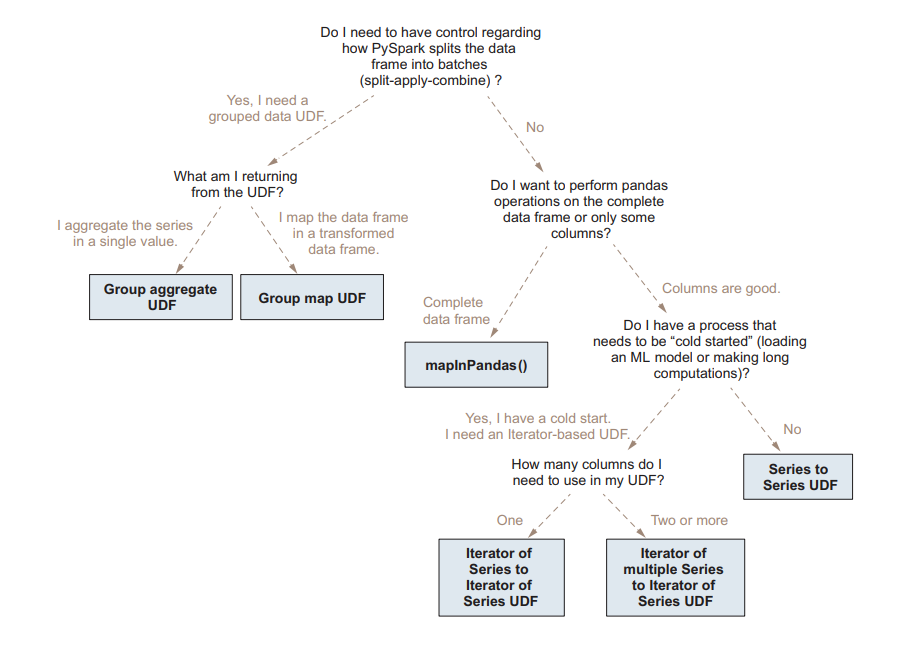